# BERT vs HMM Performance Comparison

- Automatically extract and compare PTB metrics from the **saved outputs** of `bert.ipynb` and `HMM_Ver3.ipynb`.
- Both notebooks should be executed and saved beforehand for reliable extraction.

In [7]:
from pathlib import Path
import json
import re
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd()
NOTEBOOK_PATHS = {
    "bert": PROJECT_ROOT / "bert.ipynb",
    "hmm": PROJECT_ROOT / "HMM_Ver3.ipynb",
}


In [8]:
def load_notebook(path: Path) -> dict:
    if not path.exists():
        raise FileNotFoundError(f"Notebook not found: {path}")
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)


def collect_output_texts(nb: dict) -> list[str]:
    texts: list[str] = []
    for cell in nb.get("cells", []):
        for out in cell.get("outputs", []):
            if "text" in out:
                t = out["text"]
                texts.append("".join(t) if isinstance(t, list) else str(t))
            data = out.get("data", {}) if isinstance(out, dict) else {}
            tp = data.get("text/plain")
            if tp is not None:
                texts.append("".join(tp) if isinstance(tp, list) else str(tp))
    return texts


def extract_bert_metrics(nb: dict) -> dict:
    texts = "\n".join(collect_output_texts(nb))

    acc_matches = re.findall(r"Token-level accuracy:\s*([0-9]*\.?[0-9]+)", texts)
    token_accuracy = float(acc_matches[-1]) if acc_matches else None

    macro_match = re.search(
        r"macro avg\s+([0-9]*\.?[0-9]+)\s+([0-9]*\.?[0-9]+)\s+([0-9]*\.?[0-9]+)\s+([0-9]*\.?[0-9]+)",
        texts,
    )
    weighted_match = re.search(
        r"weighted avg\s+([0-9]*\.?[0-9]+)\s+([0-9]*\.?[0-9]+)\s+([0-9]*\.?[0-9]+)\s+([0-9]*\.?[0-9]+)",
        texts,
    )

    metrics = {
        "model": "BERT",
        "token_accuracy": token_accuracy,
        "macro_f1": float(macro_match.group(3)) if macro_match else None,
        "weighted_f1": float(weighted_match.group(3)) if weighted_match else None,
        "num_tokens": int(float(macro_match.group(4))) if macro_match else None,
        "source": "bert.ipynb outputs",
    }
    return metrics


def extract_hmm_metrics(nb: dict) -> dict:
    token_accuracy = None
    macro_f1 = None
    num_tokens = None

    for cell in nb.get("cells", []):
        for out in cell.get("outputs", []):
            data = out.get("data", {}) if isinstance(out, dict) else {}
            intrinsic = data.get("application/vnd.google.colaboratory.intrinsic+json")
            if not intrinsic:
                continue
            summary = intrinsic.get("summary")
            if not summary:
                continue
            try:
                summary_obj = json.loads(summary)
            except json.JSONDecodeError:
                continue

            fields = summary_obj.get("fields", [])
            extracted = {}
            for f in fields:
                col = f.get("column")
                props = f.get("properties", {})
                if col in {"token_accuracy", "macro_f1", "num_tokens"}:
                    extracted[col] = props.get("min")

            if "token_accuracy" in extracted and "macro_f1" in extracted:
                token_accuracy = float(extracted.get("token_accuracy"))
                macro_f1 = float(extracted.get("macro_f1"))
                if extracted.get("num_tokens") is not None:
                    num_tokens = int(extracted.get("num_tokens"))
                break
        if token_accuracy is not None:
            break

    if token_accuracy is None or macro_f1 is None:
        texts = "\n".join(collect_output_texts(nb))
        acc_m = re.search(r"token_accuracy\D+([0-9]*\.?[0-9]+)", texts)
        f1_m = re.search(r"macro_f1\D+([0-9]*\.?[0-9]+)", texts)
        tok_m = re.search(r"num_tokens\D+([0-9]+)", texts)
        token_accuracy = float(acc_m.group(1)) if acc_m else token_accuracy
        macro_f1 = float(f1_m.group(1)) if f1_m else macro_f1
        num_tokens = int(tok_m.group(1)) if tok_m else num_tokens

    return {
        "model": "HMM",
        "token_accuracy": token_accuracy,
        "macro_f1": macro_f1,
        "weighted_f1": None,
        "num_tokens": num_tokens,
        "source": "HMM_Ver3.ipynb outputs",
    }


In [9]:
bert_nb = load_notebook(NOTEBOOK_PATHS["bert"])
hmm_nb = load_notebook(NOTEBOOK_PATHS["hmm"])

bert_metrics = extract_bert_metrics(bert_nb)
hmm_metrics = extract_hmm_metrics(hmm_nb)

comparison_df = pd.DataFrame([bert_metrics, hmm_metrics])
comparison_df

,model,token_accuracy,macro_f1,weighted_f1,num_tokens,source
0,BERT,0.981500,0.896500,0.9815,20532,bert.ipynb outputs
1,HMM,0.908407,0.720878,NaN,19674,HMM_Ver3.ipynb outputs


In [10]:
metric_cols = ["token_accuracy", "macro_f1", "weighted_f1"]
available_cols = [c for c in metric_cols if comparison_df[c].notna().any()]

display_df = comparison_df[["model", *available_cols, "num_tokens", "source"]].copy()
display_df = display_df.sort_values("model").reset_index(drop=True)
display_df

,model,token_accuracy,macro_f1,weighted_f1,num_tokens,source
0,BERT,0.981500,0.896500,0.9815,20532,bert.ipynb outputs
1,HMM,0.908407,0.720878,NaN,19674,HMM_Ver3.ipynb outputs


In [11]:
long_df = comparison_df.melt(
    id_vars=["model"],
    value_vars=[c for c in ["token_accuracy", "macro_f1"] if comparison_df[c].notna().any()],
    var_name="metric",
    value_name="value",
).dropna()

pivot_df = long_df.pivot(index="metric", columns="model", values="value")
pivot_df["abs_diff(BERT-HMM)"] = pivot_df.get("BERT", 0) - pivot_df.get("HMM", 0)
pivot_df

model,BERT,HMM,abs_diff(BERT-HMM)
metric,,,
macro_f1,0.8965,0.720878,0.175622
token_accuracy,0.9815,0.908407,0.073093


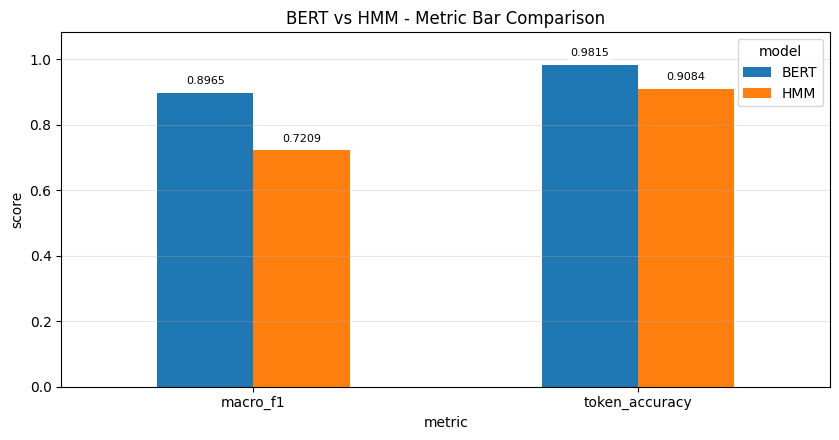

model,metric,BERT,HMM,abs_diff(BERT-HMM),rel_improve_vs_HMM(%)
0,macro_f1,0.8965,0.7209,+0.1756,+24.36%
1,token_accuracy,0.9815,0.9084,+0.0731,+8.05%


In [12]:
bar_df = long_df.pivot(index="metric", columns="model", values="value")
max_score = float(bar_df.max().max()) if len(bar_df) > 0 else 1.0
ymax = max(1.02, max_score + 0.10)  

ax = bar_df.plot(kind="bar", figsize=(8.5, 4.5), ylim=(0, ymax), rot=0)
ax.set_title("BERT vs HMM - Metric Bar Comparison")
ax.set_xlabel("metric")
ax.set_ylabel("score")
ax.grid(axis="y", alpha=0.3)

for p in ax.patches:
    h = p.get_height()
    if pd.notna(h):
        ax.annotate(
            f"{h:.4f}",
            (p.get_x() + p.get_width() / 2, h),
            ha="center",
            va="bottom",
            fontsize=8,
            xytext=(0, 5),
            textcoords="offset points",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.75),
        )

plt.tight_layout()
plt.show()

summary_df = pivot_df.copy()
summary_df["rel_improve_vs_HMM(%)"] = (summary_df["abs_diff(BERT-HMM)"] / summary_df["HMM"]) * 100
summary_df = summary_df.reset_index()

display(
    summary_df.style.format({
        "BERT": "{:.4f}",
        "HMM": "{:.4f}",
        "abs_diff(BERT-HMM)": "{:+.4f}",
        "rel_improve_vs_HMM(%)": "{:+.2f}%",
    })
)

